## Import libraries

In [18]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import pandas as pd

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [19]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# fix randomness
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

print(tf.__version__)

2.14.0


In [20]:
# Import other libraries
import cv2

# Import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import preprocess_input function from EFFICIENTNET_V2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [21]:
# Import other libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

## Data loading

In [22]:
leaves = np.load('public_data.npz', allow_pickle=True)

# storing the data
# features (training set + validation set + test set)
X_tmp = leaves['data']
# labels (training set + validation set + test set)
y_categorical = leaves['labels']

labels = {0: 'healthy', 1:'unhealthy'}

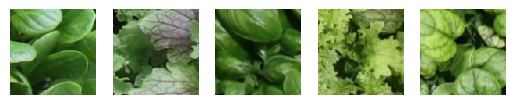

In [23]:
# Display 5 images
num_samples = 5
# randomly select 5 pics to display with no replications
sample_indices = np.random.choice(len(X_tmp), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)

    # Normalize the image data to the range [0, 1]
    normalized_image = X_tmp[idx] / 255.0  # If your original pixel values are in [0, 255]

    plt.imshow(normalized_image)
    plt.axis('off')

plt.show()

## Data pre-processing

Transform categorical labels into binary labels

In [24]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical data
y_tmp = label_encoder.fit_transform(y_categorical)

# print(y_train_val)
print(pd.Series(y_tmp).value_counts())
print("-------")
print(y_tmp.shape)
# healthy -> 0
# unhealthy -> 1

0    3199
1    2001
dtype: int64
-------
(5200,)


### Outliers Removal 

we detected outliers during training. We just remove them manually since they are only of two types.

In [25]:
# outlier detection function 
def outlier(x):
    return (np.all(x==X_tmp[58]) or np.all(x==X_tmp[412]))

# Identify non-outlier indices
non_outlier_indices = ~np.array([outlier(x) for x in X_tmp])

outlier_indices = np.array([outlier(x) for x in X_tmp])

outliers = X_tmp[outlier_indices]

# Create X and y arrays without outliers
X_default = X_tmp[non_outlier_indices]
y_default = y_tmp[non_outlier_indices]

# Print the result
# print("X:", X)
# print("y:", y)

In [26]:
X_default.shape

(5004, 96, 96, 3)

In [27]:
y_default.shape

(5004,)

In [28]:
outliers.shape

(196, 96, 96, 3)

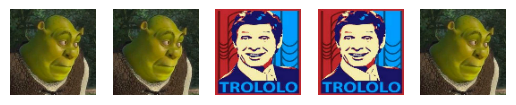

In [29]:
# Display 5 images
num_samples = 5
# randomly select 5 pics to display with no replications
sample_indices = np.random.choice(len(outliers), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)

    # Normalize the image data to the range [0, 1]
    normalized_image = outliers[idx] / 255.0  # If your original pixel values are in [0, 255]

    plt.imshow(normalized_image)
    plt.axis('off')

plt.show()

In [30]:
# print(y_train_val)
print(pd.Series(y_default).value_counts())

0    3101
1    1903
dtype: int64


In [31]:
X = X_default
y = y_default

### Data splitting

#### Manual Split

In order to achieve a more accurate training and evaluation process, we decided to split the dataset manually by setting the exact number of samples for each subsets.
The dataset is split to 3 subsets: train, validation and test.

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Assuming X is your image data and y is your labels
# X.shape should be (5004, 96, 96, 3)
# y.shape should be (5004,)

# Find indices for each class
indices_class_0 = np.where(y == 0)[0]
indices_class_1 = np.where(y == 1)[0]

# Split each class into train and test
X_train_class_0, X_test_class_0, y_train_class_0, y_test_class_0 = train_test_split(
    X[indices_class_0], y[indices_class_0], test_size=500, random_state=seed
)

X_train_class_1, X_test_class_1, y_train_class_1, y_test_class_1 = train_test_split(
    X[indices_class_1], y[indices_class_1], test_size=500, random_state=seed
)

# More Balanced training set
X_val_test = shuffle(np.concatenate([X_test_class_0, X_test_class_1], axis=0), random_state = seed)
y_val_test = shuffle(np.concatenate([y_test_class_0, y_test_class_1], axis=0), random_state = seed)
X_train = np.concatenate([X_train_class_0, X_train_class_1], axis=0)
y_train = np.concatenate([y_train_class_0, y_train_class_1], axis=0)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state=seed, shuffle = True)

print(f"train \n{pd.Series(y_train).value_counts()}")
print(f"val\n{pd.Series(y_val).value_counts()}")
print(f"test\n{pd.Series(y_test).value_counts()}")

train 
0    2601
1    1403
dtype: int64
val
1    250
0    250
dtype: int64
test
1    250
0    250
dtype: int64


In [33]:
#Randomly choose images from class 1 ('unhealthy') and apply data augmentation on it

unique, counts = np.unique(y_train, return_counts=True)
#label_difference = abs(counts[0]-counts[1])
label_difference = 600

unhealthy_indices = np.where(y_train == 1)[0]

selected_indices = np.random.choice(unhealthy_indices, label_difference, replace=False)
selected_images = X[selected_indices]

# augmentation techniques to apply
fs = [tf.image.flip_left_right, tf.image.flip_up_down, tf.image.transpose]

# randomly apply one of the aumentation technique
processed_images = np.array([np.random.choice(fs)(image) for image in selected_images])

additional_unhealthy = np.full(label_difference, '1')

X_train = shuffle(np.concatenate((X_train, processed_images), axis=0), random_state = seed)
y_train = shuffle(np.concatenate((y_train, additional_unhealthy), axis=0), random_state = seed)

# we obtained a more balanced trainingset
print(f"train \n{pd.Series(y_train).value_counts()}")

train 
0    2601
1    2003
dtype: int64


In [34]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

#### Random Split

Randomly splitting the dataset according to inserted proportion

In [15]:
# Random splitting Train Validation and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.1, random_state=seed, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1, random_state=seed, shuffle = True )
print(f"Train, Val, Test randomly split !")

Train, Val, Test randomly split !


In [16]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4052, 96, 96, 3), y_train shape: (4052,)
X_val shape: (451, 96, 96, 3), y_val shape: (451,)
X_test shape: (501, 96, 96, 3), y_test shape: (501,)


In [17]:
print(f"train: \n{pd.Series(y_train).value_counts()}")
print(f"validation: \n{pd.Series(y_val).value_counts()}")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
0    2515
1    1537
dtype: int64
validation: 
0    272
1    179
dtype: int64
test: 
0    314
1    187
dtype: int64


In [18]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

## Process of model creation

### Hyperparameters setting

In [20]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 32
epochs = 500
learning_rate = 1e-5
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 32, Epochs: 500, Learning Rate: 1e-05
Input Shape: (96, 96, 3), Output Shape: 2


In [22]:
# Pre-processing of input data is included in the EfficientNet
# EfficientNetV2 models expect their inputs to be float tensors 
# of pixels with values in the [0-255] range

### Model creation

In [23]:
supernet = tfk.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
    
)

# preprocessing layer for data augmentation
preprocessing = tfk.Sequential([
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomZoom((0,0.15),(0,0.15)),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.2, fill_mode='nearest')
], name = 'preprocessing')

# input layer
input_layer = tfkl.Input(shape = input_shape)

# resizing layer
resize_layer = tfkl.Resizing(height=224, width=224)(input_layer)

preprocess_layer = preprocessing(resize_layer)

x = tfkl.Resizing(height=224, width=224)(preprocess_layer)

x = supernet(x)

# Convert features of shape 'base_model.output_shape[1:]' to vectors
x = tfkl.GlobalAveragePooling2D()(x)

# Additional Dense Layer for adding more non-linearity
x = tfkl.Dense(
    units = 128,
    activation = 'relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
)(x)

# Dropout layer
x = tfkl.Dropout(0.3, seed=seed)(x)

# Output layer with two neurons
output_layer = (tfkl.Dense(
    units = 2,
    activation = 'softmax',
    name = 'output',
    # Initializer for the kernel weights matrix
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
))(x)

#Final model
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='EfficientNet')

### Model summary and compilation

In [24]:
supernet.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 48)   9216        ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 48)   0           ['block3b_drop[0][0]',           
          

                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 14, 14, 384)  36864       ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 14, 14, 384)  1536       ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_d

 block5b_dwconv2 (DepthwiseConv  (None, 14, 14, 672)  6048       ['block5b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 672)  0          ['block5b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 672)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 672)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5d_se_squeeze[0][0]']     
                                                                                                  
 block5d_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5d_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, 7, 7, 672)    0           ['block6a_activation[0][0]',     
                                                                  'block6a_se_expand[0][0]']      
          

                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 192)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 7, 7, 192)    0           ['block6c_drop[0][0]',           
                                                                  'block6b_add[0][0]']            
          

                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 192)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 192)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6e_add[0][0]']            
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6f_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6h_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6h_expand_activation[0][0]
 2D)      

In [25]:
model.summary()

Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 preprocessing (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                               

In [26]:
# Defining Parameters
loss = tfk.losses.BinaryCrossentropy()
optimizer = tfk.optimizers.Adam(learning_rate,epsilon=1e-2)
metrics = ['accuracy']

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)


In [27]:
# Define callback functions for early stopping and learning rate reduction and Model Check Point
save_dir = os.path.join('experiments')

callbacks=[
    #tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    #tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=25, min_lr=1e-6, mode='max')
    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_dir, 'epoch{epoch:02d}'),
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True,# True to save only the best epoch
                                                     monitor='val_accuracy')
]

### Model Training

In [28]:
# Training the model 
# we do not use preprocessing functions because EfficientNetV2 does not require any
history = model.fit(
    x = X_train, 
    y = y_train,
    validation_data = (X_val,y_val),
    epochs = 500,
    batch_size=batch_size,
    shuffle=True,
    #animate a bar
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/500
127/127 [==============================] - ETA: 0s - loss: 0.7318 - accuracy: 0.4240

127/127 [==============================] - 84s 586ms/step - loss: 0.7318 - accuracy: 0.4240 - val_loss: 0.7233 - val_accuracy: 0.4457
Epoch 2/500
127/127 [==============================] - ETA: 0s - loss: 0.7275 - accuracy: 0.4504

127/127 [==============================] - 73s 573ms/step - loss: 0.7275 - accuracy: 0.4504 - val_loss: 0.7198 - val_accuracy: 0.4479
Epoch 3/500
127/127 [==============================] - 44s 343ms/step - loss: 0.7228 - accuracy: 0.4603 - val_loss: 0.7193 - val_accuracy: 0.4435
Epoch 4/500
127/127 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.4679

127/127 [==============================] - 73s 577ms/step - loss: 0.7187 - accuracy: 0.4679 - val_loss: 0.7157 - val_accuracy: 0.4590
Epoch 5/500
127/127 [==============================] - ETA: 0s - loss: 0.7101 - accuracy: 0.4869

127/127 [==============================] - 73s 577ms/step - loss: 0.7101 - accuracy: 0.4869 - val_loss: 0.7150 - val_accuracy: 0.4612
Epoch 6/500
127/127 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.5054

127/127 [==============================] - 73s 576ms/step - loss: 0.7074 - accuracy: 0.5054 - val_loss: 0.7114 - val_accuracy: 0.4656
Epoch 7/500
127/127 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.5010

127/127 [==============================] - 73s 575ms/step - loss: 0.7049 - accuracy: 0.5010 - val_loss: 0.7097 - val_accuracy: 0.4812
Epoch 8/500
127/127 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.5286

127/127 [==============================] - 74s 582ms/step - loss: 0.6987 - accuracy: 0.5286 - val_loss: 0.7059 - val_accuracy: 0.4945
Epoch 9/500
127/127 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.5343

127/127 [==============================] - 74s 580ms/step - loss: 0.6952 - accuracy: 0.5343 - val_loss: 0.7015 - val_accuracy: 0.5166
Epoch 10/500
127/127 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.5518

127/127 [==============================] - 75s 586ms/step - loss: 0.6890 - accuracy: 0.5518 - val_loss: 0.6995 - val_accuracy: 0.5188
Epoch 11/500
127/127 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.5691

127/127 [==============================] - 74s 578ms/step - loss: 0.6868 - accuracy: 0.5691 - val_loss: 0.6954 - val_accuracy: 0.5632
Epoch 12/500
127/127 [==============================] - 44s 346ms/step - loss: 0.6793 - accuracy: 0.5891 - val_loss: 0.6934 - val_accuracy: 0.5543
Epoch 13/500
127/127 [==============================] - 44s 349ms/step - loss: 0.6766 - accuracy: 0.5960 - val_loss: 0.6920 - val_accuracy: 0.5610
Epoch 14/500
127/127 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.5960

127/127 [==============================] - 74s 582ms/step - loss: 0.6756 - accuracy: 0.5960 - val_loss: 0.6866 - val_accuracy: 0.5743
Epoch 15/500
127/127 [==============================] - 45s 353ms/step - loss: 0.6701 - accuracy: 0.6101 - val_loss: 0.6840 - val_accuracy: 0.5743
Epoch 16/500
127/127 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.6239

127/127 [==============================] - 74s 582ms/step - loss: 0.6655 - accuracy: 0.6239 - val_loss: 0.6804 - val_accuracy: 0.6009
Epoch 17/500
127/127 [==============================] - 44s 346ms/step - loss: 0.6639 - accuracy: 0.6293 - val_loss: 0.6768 - val_accuracy: 0.6009
Epoch 18/500
127/127 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.6422

127/127 [==============================] - 73s 580ms/step - loss: 0.6582 - accuracy: 0.6422 - val_loss: 0.6744 - val_accuracy: 0.6053
Epoch 19/500
127/127 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.6394

127/127 [==============================] - 74s 583ms/step - loss: 0.6569 - accuracy: 0.6394 - val_loss: 0.6705 - val_accuracy: 0.6142
Epoch 20/500
127/127 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.6347

127/127 [==============================] - 73s 577ms/step - loss: 0.6543 - accuracy: 0.6347 - val_loss: 0.6654 - val_accuracy: 0.6275
Epoch 21/500
127/127 [==============================] - 45s 350ms/step - loss: 0.6475 - accuracy: 0.6533 - val_loss: 0.6637 - val_accuracy: 0.6231
Epoch 22/500
127/127 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.6587

127/127 [==============================] - 89s 701ms/step - loss: 0.6476 - accuracy: 0.6587 - val_loss: 0.6603 - val_accuracy: 0.6364
Epoch 23/500
127/127 [==============================] - 60s 470ms/step - loss: 0.6441 - accuracy: 0.6602 - val_loss: 0.6536 - val_accuracy: 0.6319
Epoch 24/500
127/127 [==============================] - 55s 432ms/step - loss: 0.6366 - accuracy: 0.6641 - val_loss: 0.6505 - val_accuracy: 0.6364
Epoch 25/500
127/127 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.6649

127/127 [==============================] - 91s 718ms/step - loss: 0.6388 - accuracy: 0.6649 - val_loss: 0.6479 - val_accuracy: 0.6452
Epoch 26/500
127/127 [==============================] - ETA: 0s - loss: 0.6289 - accuracy: 0.6829

127/127 [==============================] - 100s 787ms/step - loss: 0.6289 - accuracy: 0.6829 - val_loss: 0.6443 - val_accuracy: 0.6497
Epoch 27/500
127/127 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.6718

127/127 [==============================] - 100s 787ms/step - loss: 0.6285 - accuracy: 0.6718 - val_loss: 0.6388 - val_accuracy: 0.6519
Epoch 28/500
127/127 [==============================] - 64s 501ms/step - loss: 0.6191 - accuracy: 0.6878 - val_loss: 0.6338 - val_accuracy: 0.6497
Epoch 29/500
127/127 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.6856

127/127 [==============================] - 101s 797ms/step - loss: 0.6222 - accuracy: 0.6856 - val_loss: 0.6307 - val_accuracy: 0.6541
Epoch 30/500
127/127 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.6992

127/127 [==============================] - 93s 735ms/step - loss: 0.6099 - accuracy: 0.6992 - val_loss: 0.6289 - val_accuracy: 0.6585
Epoch 31/500
127/127 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.6987

127/127 [==============================] - 81s 640ms/step - loss: 0.6108 - accuracy: 0.6987 - val_loss: 0.6229 - val_accuracy: 0.6652
Epoch 32/500
127/127 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.6945

127/127 [==============================] - 84s 665ms/step - loss: 0.6072 - accuracy: 0.6945 - val_loss: 0.6224 - val_accuracy: 0.6741
Epoch 33/500
127/127 [==============================] - ETA: 0s - loss: 0.6021 - accuracy: 0.7061

127/127 [==============================] - 81s 640ms/step - loss: 0.6021 - accuracy: 0.7061 - val_loss: 0.6199 - val_accuracy: 0.6763
Epoch 34/500
127/127 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.7103

127/127 [==============================] - 82s 645ms/step - loss: 0.5968 - accuracy: 0.7103 - val_loss: 0.6147 - val_accuracy: 0.6807
Epoch 35/500
127/127 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.7115

127/127 [==============================] - 82s 643ms/step - loss: 0.5906 - accuracy: 0.7115 - val_loss: 0.6085 - val_accuracy: 0.6851
Epoch 36/500
127/127 [==============================] - ETA: 0s - loss: 0.5895 - accuracy: 0.7177

127/127 [==============================] - 82s 648ms/step - loss: 0.5895 - accuracy: 0.7177 - val_loss: 0.6055 - val_accuracy: 0.6918
Epoch 37/500
127/127 [==============================] - 51s 397ms/step - loss: 0.5849 - accuracy: 0.7162 - val_loss: 0.6043 - val_accuracy: 0.6874
Epoch 38/500
127/127 [==============================] - ETA: 0s - loss: 0.5740 - accuracy: 0.7305

127/127 [==============================] - 81s 643ms/step - loss: 0.5740 - accuracy: 0.7305 - val_loss: 0.6004 - val_accuracy: 0.6940
Epoch 39/500
127/127 [==============================] - 51s 396ms/step - loss: 0.5723 - accuracy: 0.7312 - val_loss: 0.6000 - val_accuracy: 0.6851
Epoch 40/500
127/127 [==============================] - 51s 399ms/step - loss: 0.5698 - accuracy: 0.7322 - val_loss: 0.5959 - val_accuracy: 0.6896
Epoch 41/500
127/127 [==============================] - 50s 396ms/step - loss: 0.5666 - accuracy: 0.7330 - val_loss: 0.5927 - val_accuracy: 0.6896
Epoch 42/500
127/127 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.7335

127/127 [==============================] - 82s 645ms/step - loss: 0.5636 - accuracy: 0.7335 - val_loss: 0.5882 - val_accuracy: 0.6984
Epoch 43/500
127/127 [==============================] - 50s 394ms/step - loss: 0.5513 - accuracy: 0.7480 - val_loss: 0.5884 - val_accuracy: 0.6940
Epoch 44/500
127/127 [==============================] - 50s 396ms/step - loss: 0.5553 - accuracy: 0.7399 - val_loss: 0.5898 - val_accuracy: 0.6874
Epoch 45/500
127/127 [==============================] - 50s 394ms/step - loss: 0.5489 - accuracy: 0.7500 - val_loss: 0.5833 - val_accuracy: 0.6962
Epoch 46/500
127/127 [==============================] - 50s 394ms/step - loss: 0.5414 - accuracy: 0.7510 - val_loss: 0.5823 - val_accuracy: 0.6896
Epoch 47/500
127/127 [==============================] - 51s 401ms/step - loss: 0.5386 - accuracy: 0.7643 - val_loss: 0.5814 - val_accuracy: 0.6984
Epoch 48/500
127/127 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.7547

127/127 [==============================] - 81s 637ms/step - loss: 0.5380 - accuracy: 0.7547 - val_loss: 0.5760 - val_accuracy: 0.7007
Epoch 49/500
127/127 [==============================] - 54s 420ms/step - loss: 0.5260 - accuracy: 0.7655 - val_loss: 0.5775 - val_accuracy: 0.6962
Epoch 50/500
127/127 [==============================] - 48s 381ms/step - loss: 0.5258 - accuracy: 0.7614 - val_loss: 0.5788 - val_accuracy: 0.6962
Epoch 51/500
127/127 [==============================] - 51s 401ms/step - loss: 0.5216 - accuracy: 0.7648 - val_loss: 0.5736 - val_accuracy: 0.6984
Epoch 52/500
127/127 [==============================] - 50s 398ms/step - loss: 0.5181 - accuracy: 0.7670 - val_loss: 0.5761 - val_accuracy: 0.6984
Epoch 53/500
127/127 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.7707

127/127 [==============================] - 81s 643ms/step - loss: 0.5161 - accuracy: 0.7707 - val_loss: 0.5736 - val_accuracy: 0.7073
Epoch 54/500
127/127 [==============================] - 51s 399ms/step - loss: 0.5100 - accuracy: 0.7697 - val_loss: 0.5715 - val_accuracy: 0.7051
Epoch 55/500
127/127 [==============================] - 50s 397ms/step - loss: 0.5011 - accuracy: 0.7796 - val_loss: 0.5803 - val_accuracy: 0.6896
Epoch 56/500
127/127 [==============================] - 51s 400ms/step - loss: 0.5032 - accuracy: 0.7715 - val_loss: 0.5686 - val_accuracy: 0.7029
Epoch 57/500
127/127 [==============================] - 50s 397ms/step - loss: 0.5073 - accuracy: 0.7685 - val_loss: 0.5751 - val_accuracy: 0.7029
Epoch 58/500
127/127 [==============================] - 51s 398ms/step - loss: 0.4983 - accuracy: 0.7747 - val_loss: 0.5771 - val_accuracy: 0.6918
Epoch 59/500
127/127 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.7821

127/127 [==============================] - 81s 641ms/step - loss: 0.4958 - accuracy: 0.7821 - val_loss: 0.5691 - val_accuracy: 0.7095
Epoch 60/500
127/127 [==============================] - 52s 408ms/step - loss: 0.4886 - accuracy: 0.7848 - val_loss: 0.5681 - val_accuracy: 0.7095
Epoch 61/500
127/127 [==============================] - 52s 406ms/step - loss: 0.4897 - accuracy: 0.7808 - val_loss: 0.5642 - val_accuracy: 0.7029
Epoch 62/500
127/127 [==============================] - 51s 399ms/step - loss: 0.4805 - accuracy: 0.7865 - val_loss: 0.5564 - val_accuracy: 0.7073
Epoch 63/500
127/127 [==============================] - 50s 396ms/step - loss: 0.4787 - accuracy: 0.7823 - val_loss: 0.5602 - val_accuracy: 0.7095
Epoch 64/500
127/127 [==============================] - 51s 399ms/step - loss: 0.4830 - accuracy: 0.7759 - val_loss: 0.5627 - val_accuracy: 0.7007
Epoch 65/500
127/127 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.7863

127/127 [==============================] - 81s 641ms/step - loss: 0.4765 - accuracy: 0.7863 - val_loss: 0.5503 - val_accuracy: 0.7162
Epoch 66/500
127/127 [==============================] - 51s 402ms/step - loss: 0.4731 - accuracy: 0.7900 - val_loss: 0.5692 - val_accuracy: 0.6984
Epoch 67/500
127/127 [==============================] - 50s 397ms/step - loss: 0.4665 - accuracy: 0.7959 - val_loss: 0.5477 - val_accuracy: 0.7162
Epoch 68/500
127/127 [==============================] - 50s 396ms/step - loss: 0.4735 - accuracy: 0.7813 - val_loss: 0.5612 - val_accuracy: 0.7095
Epoch 69/500
127/127 [==============================] - 50s 397ms/step - loss: 0.4683 - accuracy: 0.7890 - val_loss: 0.5541 - val_accuracy: 0.7095
Epoch 70/500
127/127 [==============================] - 50s 395ms/step - loss: 0.4624 - accuracy: 0.7878 - val_loss: 0.5578 - val_accuracy: 0.7095
Epoch 71/500
127/127 [==============================] - 52s 406ms/step - loss: 0.4620 - accuracy: 0.7922 - val_loss: 0.5598 - val_a

127/127 [==============================] - 82s 645ms/step - loss: 0.4604 - accuracy: 0.7868 - val_loss: 0.5456 - val_accuracy: 0.7206
Epoch 74/500
127/127 [==============================] - 50s 397ms/step - loss: 0.4524 - accuracy: 0.7947 - val_loss: 0.5578 - val_accuracy: 0.7095
Epoch 75/500
127/127 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.7932

127/127 [==============================] - 82s 644ms/step - loss: 0.4512 - accuracy: 0.7932 - val_loss: 0.5352 - val_accuracy: 0.7273
Epoch 76/500
127/127 [==============================] - 51s 398ms/step - loss: 0.4571 - accuracy: 0.7873 - val_loss: 0.5456 - val_accuracy: 0.7162
Epoch 77/500
127/127 [==============================] - 50s 396ms/step - loss: 0.4369 - accuracy: 0.8060 - val_loss: 0.5425 - val_accuracy: 0.7251
Epoch 78/500
127/127 [==============================] - 50s 398ms/step - loss: 0.4417 - accuracy: 0.8070 - val_loss: 0.5629 - val_accuracy: 0.7073
Epoch 79/500
127/127 [==============================] - 49s 388ms/step - loss: 0.4438 - accuracy: 0.7981 - val_loss: 0.5446 - val_accuracy: 0.7228
Epoch 80/500
127/127 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.8031

127/127 [==============================] - 82s 648ms/step - loss: 0.4360 - accuracy: 0.8031 - val_loss: 0.5421 - val_accuracy: 0.7317
Epoch 81/500
127/127 [==============================] - 51s 398ms/step - loss: 0.4399 - accuracy: 0.8013 - val_loss: 0.5480 - val_accuracy: 0.7184
Epoch 82/500
127/127 [==============================] - 50s 395ms/step - loss: 0.4404 - accuracy: 0.7989 - val_loss: 0.5647 - val_accuracy: 0.7051
Epoch 83/500
127/127 [==============================] - 50s 398ms/step - loss: 0.4371 - accuracy: 0.7999 - val_loss: 0.5430 - val_accuracy: 0.7251
Epoch 84/500
127/127 [==============================] - 50s 396ms/step - loss: 0.4334 - accuracy: 0.8112 - val_loss: 0.5735 - val_accuracy: 0.7051
Epoch 85/500
127/127 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.8184

127/127 [==============================] - 80s 630ms/step - loss: 0.4218 - accuracy: 0.8184 - val_loss: 0.5311 - val_accuracy: 0.7406
Epoch 86/500
127/127 [==============================] - 47s 370ms/step - loss: 0.4275 - accuracy: 0.8045 - val_loss: 0.5279 - val_accuracy: 0.7406
Epoch 87/500
127/127 [==============================] - 45s 353ms/step - loss: 0.4211 - accuracy: 0.8129 - val_loss: 0.5491 - val_accuracy: 0.7251
Epoch 88/500
127/127 [==============================] - 44s 349ms/step - loss: 0.4194 - accuracy: 0.8154 - val_loss: 0.5486 - val_accuracy: 0.7295
Epoch 89/500
127/127 [==============================] - 44s 347ms/step - loss: 0.4229 - accuracy: 0.8102 - val_loss: 0.5486 - val_accuracy: 0.7228
Epoch 90/500
127/127 [==============================] - 44s 347ms/step - loss: 0.4258 - accuracy: 0.8107 - val_loss: 0.5447 - val_accuracy: 0.7251
Epoch 91/500
127/127 [==============================] - 44s 347ms/step - loss: 0.4204 - accuracy: 0.8144 - val_loss: 0.5474 - val_a

127/127 [==============================] - 75s 590ms/step - loss: 0.4096 - accuracy: 0.8161 - val_loss: 0.5119 - val_accuracy: 0.7428
Epoch 97/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3990 - accuracy: 0.8243 - val_loss: 0.5162 - val_accuracy: 0.7428
Epoch 98/500
127/127 [==============================] - 44s 347ms/step - loss: 0.4060 - accuracy: 0.8206 - val_loss: 0.5312 - val_accuracy: 0.7428
Epoch 99/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3935 - accuracy: 0.8223 - val_loss: 0.5266 - val_accuracy: 0.7406
Epoch 100/500
127/127 [==============================] - 44s 346ms/step - loss: 0.3972 - accuracy: 0.8240 - val_loss: 0.5220 - val_accuracy: 0.7406
Epoch 101/500
127/127 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8280

127/127 [==============================] - 74s 585ms/step - loss: 0.4008 - accuracy: 0.8280 - val_loss: 0.5216 - val_accuracy: 0.7472
Epoch 102/500
127/127 [==============================] - 44s 346ms/step - loss: 0.3988 - accuracy: 0.8189 - val_loss: 0.5244 - val_accuracy: 0.7361
Epoch 103/500
127/127 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8223

127/127 [==============================] - 74s 585ms/step - loss: 0.3916 - accuracy: 0.8223 - val_loss: 0.5037 - val_accuracy: 0.7517
Epoch 104/500
127/127 [==============================] - 44s 346ms/step - loss: 0.3995 - accuracy: 0.8221 - val_loss: 0.5149 - val_accuracy: 0.7472
Epoch 105/500
127/127 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.8245

127/127 [==============================] - 74s 587ms/step - loss: 0.3914 - accuracy: 0.8245 - val_loss: 0.4985 - val_accuracy: 0.7539
Epoch 106/500
127/127 [==============================] - 44s 346ms/step - loss: 0.3928 - accuracy: 0.8265 - val_loss: 0.5200 - val_accuracy: 0.7517
Epoch 107/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3846 - accuracy: 0.8292 - val_loss: 0.5107 - val_accuracy: 0.7406
Epoch 108/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3912 - accuracy: 0.8228 - val_loss: 0.5120 - val_accuracy: 0.7517
Epoch 109/500
127/127 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.8211

127/127 [==============================] - 72s 568ms/step - loss: 0.3939 - accuracy: 0.8211 - val_loss: 0.5117 - val_accuracy: 0.7561
Epoch 110/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3956 - accuracy: 0.8221 - val_loss: 0.5126 - val_accuracy: 0.7517
Epoch 111/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3869 - accuracy: 0.8319 - val_loss: 0.5072 - val_accuracy: 0.7561
Epoch 112/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3892 - accuracy: 0.8317 - val_loss: 0.4974 - val_accuracy: 0.7539
Epoch 113/500
127/127 [==============================] - 44s 346ms/step - loss: 0.3827 - accuracy: 0.8322 - val_loss: 0.5043 - val_accuracy: 0.7494
Epoch 114/500
127/127 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8223

127/127 [==============================] - 75s 592ms/step - loss: 0.3908 - accuracy: 0.8223 - val_loss: 0.5010 - val_accuracy: 0.7605
Epoch 115/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3744 - accuracy: 0.8337 - val_loss: 0.4991 - val_accuracy: 0.7561
Epoch 116/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3818 - accuracy: 0.8322 - val_loss: 0.5031 - val_accuracy: 0.7561
Epoch 117/500
127/127 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8329

127/127 [==============================] - 75s 589ms/step - loss: 0.3755 - accuracy: 0.8329 - val_loss: 0.4797 - val_accuracy: 0.7650
Epoch 118/500
127/127 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8423

127/127 [==============================] - 72s 567ms/step - loss: 0.3702 - accuracy: 0.8423 - val_loss: 0.4621 - val_accuracy: 0.7805
Epoch 119/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3834 - accuracy: 0.8346 - val_loss: 0.4839 - val_accuracy: 0.7627
Epoch 120/500
127/127 [==============================] - 44s 346ms/step - loss: 0.3714 - accuracy: 0.8376 - val_loss: 0.4929 - val_accuracy: 0.7583
Epoch 121/500
127/127 [==============================] - 44s 346ms/step - loss: 0.3608 - accuracy: 0.8445 - val_loss: 0.4926 - val_accuracy: 0.7605
Epoch 122/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3683 - accuracy: 0.8381 - val_loss: 0.4906 - val_accuracy: 0.7583
Epoch 123/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3718 - accuracy: 0.8388 - val_loss: 0.4970 - val_accuracy: 0.7627
Epoch 124/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3643 - accuracy: 0.8433 - val_loss: 0.4806 -

127/127 [==============================] - 75s 595ms/step - loss: 0.3644 - accuracy: 0.8458 - val_loss: 0.4631 - val_accuracy: 0.7827
Epoch 129/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3525 - accuracy: 0.8492 - val_loss: 0.4661 - val_accuracy: 0.7805
Epoch 130/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3566 - accuracy: 0.8467 - val_loss: 0.5045 - val_accuracy: 0.7561
Epoch 131/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3656 - accuracy: 0.8433 - val_loss: 0.5123 - val_accuracy: 0.7517
Epoch 132/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3528 - accuracy: 0.8480 - val_loss: 0.4931 - val_accuracy: 0.7605
Epoch 133/500
127/127 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8467

127/127 [==============================] - 75s 592ms/step - loss: 0.3549 - accuracy: 0.8467 - val_loss: 0.4696 - val_accuracy: 0.7871
Epoch 134/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3542 - accuracy: 0.8455 - val_loss: 0.4782 - val_accuracy: 0.7761
Epoch 135/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3457 - accuracy: 0.8551 - val_loss: 0.4688 - val_accuracy: 0.7871
Epoch 136/500
127/127 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.8472

127/127 [==============================] - 72s 570ms/step - loss: 0.3513 - accuracy: 0.8472 - val_loss: 0.4488 - val_accuracy: 0.7938
Epoch 137/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3499 - accuracy: 0.8462 - val_loss: 0.4597 - val_accuracy: 0.7916
Epoch 138/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3443 - accuracy: 0.8569 - val_loss: 0.4692 - val_accuracy: 0.7827
Epoch 139/500
127/127 [==============================] - 44s 346ms/step - loss: 0.3562 - accuracy: 0.8445 - val_loss: 0.4537 - val_accuracy: 0.7894
Epoch 140/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3377 - accuracy: 0.8586 - val_loss: 0.4775 - val_accuracy: 0.7783
Epoch 141/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3370 - accuracy: 0.8507 - val_loss: 0.4588 - val_accuracy: 0.7827
Epoch 142/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3446 - accuracy: 0.8495 - val_loss: 0.4534 -

127/127 [==============================] - 76s 598ms/step - loss: 0.3472 - accuracy: 0.8517 - val_loss: 0.4602 - val_accuracy: 0.7982
Epoch 144/500
127/127 [==============================] - 45s 348ms/step - loss: 0.3455 - accuracy: 0.8460 - val_loss: 0.4727 - val_accuracy: 0.7849
Epoch 145/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3495 - accuracy: 0.8480 - val_loss: 0.4673 - val_accuracy: 0.7871
Epoch 146/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3419 - accuracy: 0.8519 - val_loss: 0.4697 - val_accuracy: 0.7805
Epoch 147/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3379 - accuracy: 0.8502 - val_loss: 0.4647 - val_accuracy: 0.7871
Epoch 148/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3263 - accuracy: 0.8638 - val_loss: 0.4495 - val_accuracy: 0.7916
Epoch 149/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3344 - accuracy: 0.8546 - val_loss: 0.4630 -

127/127 [==============================] - 75s 592ms/step - loss: 0.3279 - accuracy: 0.8586 - val_loss: 0.4361 - val_accuracy: 0.8071
Epoch 152/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3290 - accuracy: 0.8613 - val_loss: 0.4582 - val_accuracy: 0.7916
Epoch 153/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3299 - accuracy: 0.8620 - val_loss: 0.4993 - val_accuracy: 0.7627
Epoch 154/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3260 - accuracy: 0.8588 - val_loss: 0.4505 - val_accuracy: 0.7916
Epoch 155/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3303 - accuracy: 0.8581 - val_loss: 0.4545 - val_accuracy: 0.7849
Epoch 156/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3346 - accuracy: 0.8578 - val_loss: 0.4394 - val_accuracy: 0.7982
Epoch 157/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3216 - accuracy: 0.8615 - val_loss: 0.4674 -

127/127 [==============================] - 72s 567ms/step - loss: 0.3338 - accuracy: 0.8593 - val_loss: 0.4231 - val_accuracy: 0.8093
Epoch 162/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3321 - accuracy: 0.8566 - val_loss: 0.4533 - val_accuracy: 0.7849
Epoch 163/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3235 - accuracy: 0.8638 - val_loss: 0.4633 - val_accuracy: 0.7894
Epoch 164/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3189 - accuracy: 0.8648 - val_loss: 0.4595 - val_accuracy: 0.7827
Epoch 165/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3200 - accuracy: 0.8640 - val_loss: 0.4480 - val_accuracy: 0.7871
Epoch 166/500
127/127 [==============================] - 44s 349ms/step - loss: 0.3223 - accuracy: 0.8566 - val_loss: 0.4412 - val_accuracy: 0.7982
Epoch 167/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3137 - accuracy: 0.8680 - val_loss: 0.4192 -

127/127 [==============================] - 76s 599ms/step - loss: 0.3134 - accuracy: 0.8714 - val_loss: 0.4022 - val_accuracy: 0.8137
Epoch 170/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3135 - accuracy: 0.8662 - val_loss: 0.4217 - val_accuracy: 0.8071
Epoch 171/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3150 - accuracy: 0.8667 - val_loss: 0.4156 - val_accuracy: 0.8137
Epoch 172/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3033 - accuracy: 0.8754 - val_loss: 0.4478 - val_accuracy: 0.7916
Epoch 173/500
127/127 [==============================] - 44s 349ms/step - loss: 0.3198 - accuracy: 0.8657 - val_loss: 0.4352 - val_accuracy: 0.7982
Epoch 174/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3142 - accuracy: 0.8640 - val_loss: 0.4298 - val_accuracy: 0.8027
Epoch 175/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3107 - accuracy: 0.8692 - val_loss: 0.4104 -

127/127 [==============================] - 72s 567ms/step - loss: 0.3092 - accuracy: 0.8714 - val_loss: 0.3944 - val_accuracy: 0.8182
Epoch 179/500
127/127 [==============================] - 44s 347ms/step - loss: 0.3112 - accuracy: 0.8635 - val_loss: 0.4112 - val_accuracy: 0.8137
Epoch 180/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3089 - accuracy: 0.8699 - val_loss: 0.4304 - val_accuracy: 0.7960
Epoch 181/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3058 - accuracy: 0.8788 - val_loss: 0.4487 - val_accuracy: 0.7916
Epoch 182/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3093 - accuracy: 0.8744 - val_loss: 0.4190 - val_accuracy: 0.8093
Epoch 183/500
127/127 [==============================] - 44s 349ms/step - loss: 0.3057 - accuracy: 0.8697 - val_loss: 0.4468 - val_accuracy: 0.7849
Epoch 184/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2987 - accuracy: 0.8749 - val_loss: 0.4022 -

127/127 [==============================] - 76s 598ms/step - loss: 0.3041 - accuracy: 0.8729 - val_loss: 0.3721 - val_accuracy: 0.8248
Epoch 191/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2950 - accuracy: 0.8754 - val_loss: 0.4184 - val_accuracy: 0.8049
Epoch 192/500
127/127 [==============================] - 44s 348ms/step - loss: 0.3101 - accuracy: 0.8690 - val_loss: 0.4154 - val_accuracy: 0.8115
Epoch 193/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2974 - accuracy: 0.8801 - val_loss: 0.3967 - val_accuracy: 0.8204
Epoch 194/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2836 - accuracy: 0.8892 - val_loss: 0.3999 - val_accuracy: 0.8160
Epoch 195/500
127/127 [==============================] - 44s 347ms/step - loss: 0.2977 - accuracy: 0.8810 - val_loss: 0.4190 - val_accuracy: 0.8182
Epoch 196/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2902 - accuracy: 0.8751 - val_loss: 0.4096 -

127/127 [==============================] - 75s 596ms/step - loss: 0.2902 - accuracy: 0.8771 - val_loss: 0.3804 - val_accuracy: 0.8271
Epoch 206/500
127/127 [==============================] - 45s 348ms/step - loss: 0.2881 - accuracy: 0.8806 - val_loss: 0.4379 - val_accuracy: 0.8071
Epoch 207/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2869 - accuracy: 0.8840 - val_loss: 0.3913 - val_accuracy: 0.8204
Epoch 208/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2840 - accuracy: 0.8835 - val_loss: 0.3754 - val_accuracy: 0.8226
Epoch 209/500
127/127 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8771

127/127 [==============================] - 72s 568ms/step - loss: 0.2991 - accuracy: 0.8771 - val_loss: 0.3885 - val_accuracy: 0.8293
Epoch 210/500
127/127 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.8781

127/127 [==============================] - 78s 616ms/step - loss: 0.2836 - accuracy: 0.8781 - val_loss: 0.3669 - val_accuracy: 0.8315
Epoch 211/500
127/127 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8860

127/127 [==============================] - 73s 570ms/step - loss: 0.2916 - accuracy: 0.8860 - val_loss: 0.3782 - val_accuracy: 0.8359
Epoch 212/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2958 - accuracy: 0.8776 - val_loss: 0.3934 - val_accuracy: 0.8226
Epoch 213/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2884 - accuracy: 0.8781 - val_loss: 0.3872 - val_accuracy: 0.8248
Epoch 214/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2828 - accuracy: 0.8813 - val_loss: 0.4019 - val_accuracy: 0.8182
Epoch 215/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2849 - accuracy: 0.8771 - val_loss: 0.3695 - val_accuracy: 0.8315
Epoch 216/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2803 - accuracy: 0.8791 - val_loss: 0.3788 - val_accuracy: 0.8315
Epoch 217/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2767 - accuracy: 0.8840 - val_loss: 0.3715 -

127/127 [==============================] - 76s 602ms/step - loss: 0.2931 - accuracy: 0.8808 - val_loss: 0.3747 - val_accuracy: 0.8426
Epoch 219/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2730 - accuracy: 0.8912 - val_loss: 0.4086 - val_accuracy: 0.8160
Epoch 220/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2803 - accuracy: 0.8808 - val_loss: 0.3621 - val_accuracy: 0.8426
Epoch 221/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2689 - accuracy: 0.8872 - val_loss: 0.3657 - val_accuracy: 0.8337
Epoch 222/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2763 - accuracy: 0.8875 - val_loss: 0.3931 - val_accuracy: 0.8226
Epoch 223/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2865 - accuracy: 0.8838 - val_loss: 0.3887 - val_accuracy: 0.8381
Epoch 224/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2791 - accuracy: 0.8845 - val_loss: 0.3510 -

127/127 [==============================] - 72s 569ms/step - loss: 0.2620 - accuracy: 0.8909 - val_loss: 0.3435 - val_accuracy: 0.8492
Epoch 228/500
127/127 [==============================] - 45s 349ms/step - loss: 0.2782 - accuracy: 0.8875 - val_loss: 0.3615 - val_accuracy: 0.8470
Epoch 229/500
127/127 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.8875

127/127 [==============================] - 77s 607ms/step - loss: 0.2716 - accuracy: 0.8875 - val_loss: 0.3399 - val_accuracy: 0.8537
Epoch 230/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2650 - accuracy: 0.8912 - val_loss: 0.3650 - val_accuracy: 0.8426
Epoch 231/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2675 - accuracy: 0.8931 - val_loss: 0.3705 - val_accuracy: 0.8448
Epoch 232/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2599 - accuracy: 0.9005 - val_loss: 0.3843 - val_accuracy: 0.8381
Epoch 233/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2703 - accuracy: 0.8899 - val_loss: 0.3625 - val_accuracy: 0.8448
Epoch 234/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2722 - accuracy: 0.8857 - val_loss: 0.3624 - val_accuracy: 0.8448
Epoch 235/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2730 - accuracy: 0.8875 - val_loss: 0.4079 -

127/127 [==============================] - 72s 569ms/step - loss: 0.2535 - accuracy: 0.8951 - val_loss: 0.3429 - val_accuracy: 0.8559
Epoch 260/500
127/127 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.8981

127/127 [==============================] - 77s 604ms/step - loss: 0.2530 - accuracy: 0.8981 - val_loss: 0.3471 - val_accuracy: 0.8603
Epoch 261/500
127/127 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.8926

127/127 [==============================] - 72s 568ms/step - loss: 0.2638 - accuracy: 0.8926 - val_loss: 0.3275 - val_accuracy: 0.8625
Epoch 262/500
127/127 [==============================] - 44s 347ms/step - loss: 0.2481 - accuracy: 0.9003 - val_loss: 0.3362 - val_accuracy: 0.8625
Epoch 263/500
127/127 [==============================] - 44s 347ms/step - loss: 0.2588 - accuracy: 0.8931 - val_loss: 0.3515 - val_accuracy: 0.8448
Epoch 264/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2604 - accuracy: 0.8961 - val_loss: 0.3396 - val_accuracy: 0.8603
Epoch 265/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2668 - accuracy: 0.8902 - val_loss: 0.3423 - val_accuracy: 0.8559
Epoch 266/500
127/127 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.8904

127/127 [==============================] - 77s 605ms/step - loss: 0.2562 - accuracy: 0.8904 - val_loss: 0.3176 - val_accuracy: 0.8714
Epoch 267/500
127/127 [==============================] - 45s 349ms/step - loss: 0.2408 - accuracy: 0.9008 - val_loss: 0.3337 - val_accuracy: 0.8581
Epoch 268/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2492 - accuracy: 0.8983 - val_loss: 0.3439 - val_accuracy: 0.8514
Epoch 269/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2460 - accuracy: 0.8956 - val_loss: 0.3231 - val_accuracy: 0.8559
Epoch 270/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2547 - accuracy: 0.8966 - val_loss: 0.3566 - val_accuracy: 0.8537
Epoch 271/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2396 - accuracy: 0.9010 - val_loss: 0.3292 - val_accuracy: 0.8581
Epoch 272/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2435 - accuracy: 0.9072 - val_loss: 0.3602 -

127/127 [==============================] - 72s 569ms/step - loss: 0.2384 - accuracy: 0.9052 - val_loss: 0.2901 - val_accuracy: 0.8780
Epoch 315/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2304 - accuracy: 0.9060 - val_loss: 0.3124 - val_accuracy: 0.8647
Epoch 316/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2374 - accuracy: 0.9003 - val_loss: 0.3378 - val_accuracy: 0.8625
Epoch 317/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2302 - accuracy: 0.9082 - val_loss: 0.3382 - val_accuracy: 0.8537
Epoch 318/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2271 - accuracy: 0.9104 - val_loss: 0.3051 - val_accuracy: 0.8692
Epoch 319/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2330 - accuracy: 0.9045 - val_loss: 0.3245 - val_accuracy: 0.8647
Epoch 320/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2259 - accuracy: 0.9104 - val_loss: 0.2914 -

127/127 [==============================] - 77s 608ms/step - loss: 0.2056 - accuracy: 0.9181 - val_loss: 0.2890 - val_accuracy: 0.8847
Epoch 377/500
127/127 [==============================] - 45s 349ms/step - loss: 0.2141 - accuracy: 0.9136 - val_loss: 0.3068 - val_accuracy: 0.8692
Epoch 378/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2052 - accuracy: 0.9171 - val_loss: 0.3296 - val_accuracy: 0.8714
Epoch 379/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2051 - accuracy: 0.9173 - val_loss: 0.3175 - val_accuracy: 0.8692
Epoch 380/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2097 - accuracy: 0.9131 - val_loss: 0.2993 - val_accuracy: 0.8758
Epoch 381/500
127/127 [==============================] - 44s 350ms/step - loss: 0.2123 - accuracy: 0.9178 - val_loss: 0.2878 - val_accuracy: 0.8780
Epoch 382/500
127/127 [==============================] - 44s 350ms/step - loss: 0.2159 - accuracy: 0.9139 - val_loss: 0.2857 -

127/127 [==============================] - 72s 568ms/step - loss: 0.2099 - accuracy: 0.9181 - val_loss: 0.2746 - val_accuracy: 0.8914
Epoch 399/500
127/127 [==============================] - 45s 348ms/step - loss: 0.1965 - accuracy: 0.9232 - val_loss: 0.2806 - val_accuracy: 0.8803
Epoch 400/500
127/127 [==============================] - 44s 348ms/step - loss: 0.1991 - accuracy: 0.9188 - val_loss: 0.3069 - val_accuracy: 0.8780
Epoch 401/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2080 - accuracy: 0.9134 - val_loss: 0.2934 - val_accuracy: 0.8803
Epoch 402/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2005 - accuracy: 0.9208 - val_loss: 0.2779 - val_accuracy: 0.8869
Epoch 403/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2023 - accuracy: 0.9183 - val_loss: 0.2839 - val_accuracy: 0.8891
Epoch 404/500
127/127 [==============================] - 44s 348ms/step - loss: 0.2005 - accuracy: 0.9198 - val_loss: 0.2863 -

127/127 [==============================] - 72s 571ms/step - loss: 0.2035 - accuracy: 0.9186 - val_loss: 0.2738 - val_accuracy: 0.8936
Epoch 418/500
127/127 [==============================] - 44s 348ms/step - loss: 0.1967 - accuracy: 0.9242 - val_loss: 0.3280 - val_accuracy: 0.8714
Epoch 419/500
127/127 [==============================] - 44s 348ms/step - loss: 0.1991 - accuracy: 0.9195 - val_loss: 0.3411 - val_accuracy: 0.8692
Epoch 420/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1968 - accuracy: 0.9257 - val_loss: 0.2839 - val_accuracy: 0.8847
Epoch 421/500
127/127 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9267

127/127 [==============================] - 78s 614ms/step - loss: 0.1890 - accuracy: 0.9267 - val_loss: 0.2708 - val_accuracy: 0.8958
Epoch 422/500
127/127 [==============================] - 45s 349ms/step - loss: 0.2009 - accuracy: 0.9188 - val_loss: 0.3332 - val_accuracy: 0.8647
Epoch 423/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1918 - accuracy: 0.9274 - val_loss: 0.3125 - val_accuracy: 0.8869
Epoch 424/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1912 - accuracy: 0.9240 - val_loss: 0.2683 - val_accuracy: 0.8936
Epoch 425/500
127/127 [==============================] - 44s 349ms/step - loss: 0.2005 - accuracy: 0.9193 - val_loss: 0.3165 - val_accuracy: 0.8803
Epoch 426/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1882 - accuracy: 0.9267 - val_loss: 0.3005 - val_accuracy: 0.8869
Epoch 427/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1891 - accuracy: 0.9282 - val_loss: 0.3094 -

127/127 [==============================] - 72s 570ms/step - loss: 0.1861 - accuracy: 0.9294 - val_loss: 0.2574 - val_accuracy: 0.9069
Epoch 478/500
127/127 [==============================] - 45s 349ms/step - loss: 0.1719 - accuracy: 0.9319 - val_loss: 0.2706 - val_accuracy: 0.8958
Epoch 479/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1763 - accuracy: 0.9289 - val_loss: 0.2644 - val_accuracy: 0.8936
Epoch 480/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1799 - accuracy: 0.9297 - val_loss: 0.2880 - val_accuracy: 0.8914
Epoch 481/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1831 - accuracy: 0.9247 - val_loss: 0.2790 - val_accuracy: 0.8936
Epoch 482/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1657 - accuracy: 0.9358 - val_loss: 0.2732 - val_accuracy: 0.8980
Epoch 483/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1734 - accuracy: 0.9336 - val_loss: 0.2651 -

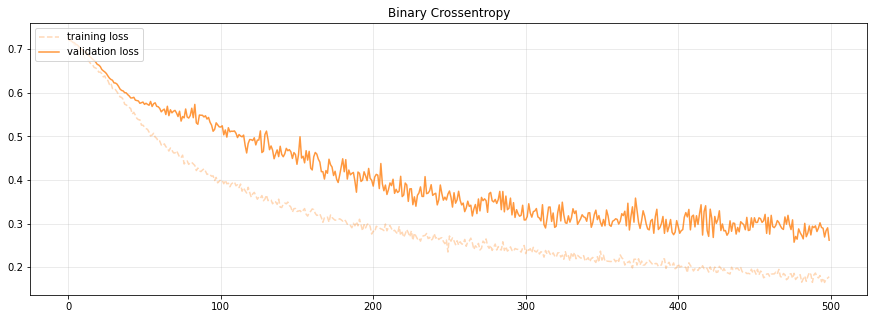

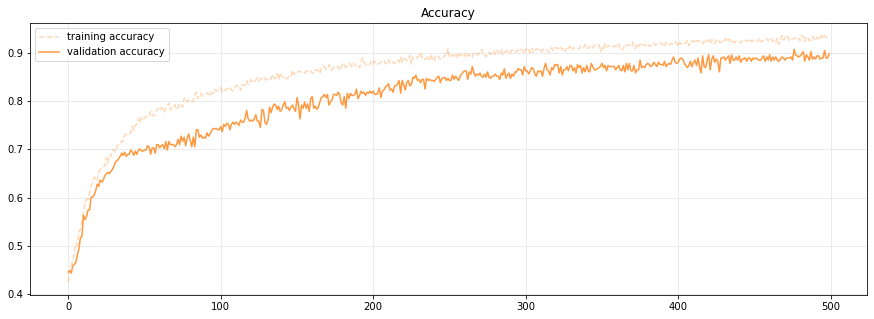

In [30]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)


plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [35]:
history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val,y_val),
    epochs = 500,
    batch_size=batch_size,
    shuffle=True,
    #animate a bar
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/500
127/127 [==============================] - 44s 347ms/step - loss: 0.1678 - accuracy: 0.9336 - val_loss: 0.2987 - val_accuracy: 0.8891
Epoch 2/500
127/127 [==============================] - 45s 351ms/step - loss: 0.1737 - accuracy: 0.9339 - val_loss: 0.2735 - val_accuracy: 0.8958
Epoch 3/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1791 - accuracy: 0.9309 - val_loss: 0.2752 - val_accuracy: 0.8980
Epoch 4/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1790 - accuracy: 0.9274 - val_loss: 0.2729 - val_accuracy: 0.8958
Epoch 5/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1854 - accuracy: 0.9267 - val_loss: 0.2972 - val_accuracy: 0.8914
Epoch 6/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1773 - accuracy: 0.9341 - val_loss: 0.2793 - val_accuracy: 0.8891
Epoch 7/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1755 - accuracy: 0.9252 - val_loss: 0.2909 -

Epoch 57/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1637 - accuracy: 0.9336 - val_loss: 0.2784 - val_accuracy: 0.9002
Epoch 58/500
127/127 [==============================] - 44s 348ms/step - loss: 0.1614 - accuracy: 0.9339 - val_loss: 0.2944 - val_accuracy: 0.8914
Epoch 59/500
127/127 [==============================] - 44s 348ms/step - loss: 0.1522 - accuracy: 0.9395 - val_loss: 0.2770 - val_accuracy: 0.8980
Epoch 60/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1579 - accuracy: 0.9378 - val_loss: 0.2836 - val_accuracy: 0.8958
Epoch 61/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1580 - accuracy: 0.9363 - val_loss: 0.2605 - val_accuracy: 0.9069
Epoch 62/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1638 - accuracy: 0.9385 - val_loss: 0.2610 - val_accuracy: 0.9047
Epoch 63/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1548 - accuracy: 0.9400 - val_loss: 0

127/127 [==============================] - 77s 607ms/step - loss: 0.1603 - accuracy: 0.9408 - val_loss: 0.2610 - val_accuracy: 0.9091
Epoch 71/500
127/127 [==============================] - 45s 349ms/step - loss: 0.1551 - accuracy: 0.9378 - val_loss: 0.2873 - val_accuracy: 0.8936
Epoch 72/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1569 - accuracy: 0.9371 - val_loss: 0.2928 - val_accuracy: 0.8958
Epoch 73/500
127/127 [==============================] - 44s 348ms/step - loss: 0.1535 - accuracy: 0.9460 - val_loss: 0.2731 - val_accuracy: 0.8980
Epoch 74/500
127/127 [==============================] - 44s 348ms/step - loss: 0.1633 - accuracy: 0.9373 - val_loss: 0.2668 - val_accuracy: 0.9047
Epoch 75/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1495 - accuracy: 0.9415 - val_loss: 0.2569 - val_accuracy: 0.9047
Epoch 76/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1626 - accuracy: 0.9405 - val_loss: 0.2820 - val_a

127/127 [==============================] - 72s 568ms/step - loss: 0.1344 - accuracy: 0.9460 - val_loss: 0.2625 - val_accuracy: 0.9113
Epoch 122/500
127/127 [==============================] - 45s 349ms/step - loss: 0.1451 - accuracy: 0.9464 - val_loss: 0.2838 - val_accuracy: 0.9002
Epoch 123/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1524 - accuracy: 0.9381 - val_loss: 0.2844 - val_accuracy: 0.8980
Epoch 124/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1431 - accuracy: 0.9455 - val_loss: 0.2502 - val_accuracy: 0.9091
Epoch 125/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1435 - accuracy: 0.9442 - val_loss: 0.2836 - val_accuracy: 0.8958
Epoch 126/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1454 - accuracy: 0.9398 - val_loss: 0.2668 - val_accuracy: 0.9002
Epoch 127/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1394 - accuracy: 0.9469 - val_loss: 0.3281 -

127/127 [==============================] - 77s 610ms/step - loss: 0.1406 - accuracy: 0.9469 - val_loss: 0.2579 - val_accuracy: 0.9135
Epoch 168/500
127/127 [==============================] - 45s 350ms/step - loss: 0.1403 - accuracy: 0.9447 - val_loss: 0.2724 - val_accuracy: 0.9024
Epoch 169/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1308 - accuracy: 0.9519 - val_loss: 0.2769 - val_accuracy: 0.9024
Epoch 170/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1394 - accuracy: 0.9445 - val_loss: 0.2993 - val_accuracy: 0.8936
Epoch 171/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1421 - accuracy: 0.9455 - val_loss: 0.2710 - val_accuracy: 0.9091
Epoch 172/500
127/127 [==============================] - 44s 349ms/step - loss: 0.1350 - accuracy: 0.9494 - val_loss: 0.3137 - val_accuracy: 0.8914
Epoch 173/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1419 - accuracy: 0.9425 - val_loss: 0.2974 -

127/127 [==============================] - 72s 572ms/step - loss: 0.1416 - accuracy: 0.9455 - val_loss: 0.2414 - val_accuracy: 0.9157
Epoch 191/500
127/127 [==============================] - 45s 350ms/step - loss: 0.1285 - accuracy: 0.9501 - val_loss: 0.2840 - val_accuracy: 0.8958
Epoch 192/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1309 - accuracy: 0.9492 - val_loss: 0.2799 - val_accuracy: 0.8958
Epoch 193/500
127/127 [==============================] - 45s 351ms/step - loss: 0.1212 - accuracy: 0.9529 - val_loss: 0.2727 - val_accuracy: 0.8980
Epoch 194/500
127/127 [==============================] - 45s 351ms/step - loss: 0.1360 - accuracy: 0.9447 - val_loss: 0.2591 - val_accuracy: 0.9069
Epoch 195/500
127/127 [==============================] - 45s 352ms/step - loss: 0.1343 - accuracy: 0.9457 - val_loss: 0.2702 - val_accuracy: 0.9024
Epoch 196/500
127/127 [==============================] - 45s 351ms/step - loss: 0.1373 - accuracy: 0.9435 - val_loss: 0.2782 -

127/127 [==============================] - 45s 354ms/step - loss: 0.1235 - accuracy: 0.9521 - val_loss: 0.2730 - val_accuracy: 0.9024
Epoch 301/500
127/127 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9536

127/127 [==============================] - 79s 623ms/step - loss: 0.1170 - accuracy: 0.9536 - val_loss: 0.2550 - val_accuracy: 0.9180
Epoch 302/500
127/127 [==============================] - 46s 358ms/step - loss: 0.1208 - accuracy: 0.9541 - val_loss: 0.2759 - val_accuracy: 0.9047
Epoch 303/500
127/127 [==============================] - 45s 352ms/step - loss: 0.1279 - accuracy: 0.9538 - val_loss: 0.2907 - val_accuracy: 0.9069
Epoch 304/500
127/127 [==============================] - 45s 351ms/step - loss: 0.1153 - accuracy: 0.9595 - val_loss: 0.2757 - val_accuracy: 0.9047
Epoch 305/500
127/127 [==============================] - 45s 351ms/step - loss: 0.1128 - accuracy: 0.9576 - val_loss: 0.2880 - val_accuracy: 0.9002
Epoch 306/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1174 - accuracy: 0.9558 - val_loss: 0.2642 - val_accuracy: 0.9113
Epoch 307/500
127/127 [==============================] - 46s 358ms/step - loss: 0.1160 - accuracy: 0.9558 - val_loss: 0.2761 -

127/127 [==============================] - 44s 350ms/step - loss: 0.1031 - accuracy: 0.9590 - val_loss: 0.2997 - val_accuracy: 0.9047
Epoch 412/500
127/127 [==============================] - 45s 351ms/step - loss: 0.1108 - accuracy: 0.9568 - val_loss: 0.2840 - val_accuracy: 0.9069
Epoch 413/500
127/127 [==============================] - 45s 351ms/step - loss: 0.0963 - accuracy: 0.9635 - val_loss: 0.3123 - val_accuracy: 0.8980
Epoch 414/500
127/127 [==============================] - 44s 350ms/step - loss: 0.0989 - accuracy: 0.9603 - val_loss: 0.2877 - val_accuracy: 0.9069
Epoch 415/500
127/127 [==============================] - 44s 350ms/step - loss: 0.0988 - accuracy: 0.9640 - val_loss: 0.3271 - val_accuracy: 0.8958
Epoch 416/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1089 - accuracy: 0.9595 - val_loss: 0.3208 - val_accuracy: 0.8936
Epoch 417/500
127/127 [==============================] - 44s 350ms/step - loss: 0.1062 - accuracy: 0.9568 - val_loss: 0.2683 -

127/127 [==============================] - 74s 581ms/step - loss: 0.0953 - accuracy: 0.9605 - val_loss: 0.2458 - val_accuracy: 0.9202
Epoch 478/500
127/127 [==============================] - 45s 350ms/step - loss: 0.0858 - accuracy: 0.9677 - val_loss: 0.2665 - val_accuracy: 0.9047
Epoch 479/500
127/127 [==============================] - 44s 350ms/step - loss: 0.0966 - accuracy: 0.9615 - val_loss: 0.2746 - val_accuracy: 0.9069
Epoch 480/500
127/127 [==============================] - 44s 349ms/step - loss: 0.0952 - accuracy: 0.9625 - val_loss: 0.2771 - val_accuracy: 0.9113
Epoch 481/500
127/127 [==============================] - 44s 350ms/step - loss: 0.0838 - accuracy: 0.9677 - val_loss: 0.2723 - val_accuracy: 0.9069
Epoch 482/500
127/127 [==============================] - 44s 349ms/step - loss: 0.0847 - accuracy: 0.9679 - val_loss: 0.2785 - val_accuracy: 0.9113
Epoch 483/500
127/127 [==============================] - 44s 350ms/step - loss: 0.0843 - accuracy: 0.9696 - val_loss: 0.2700 -

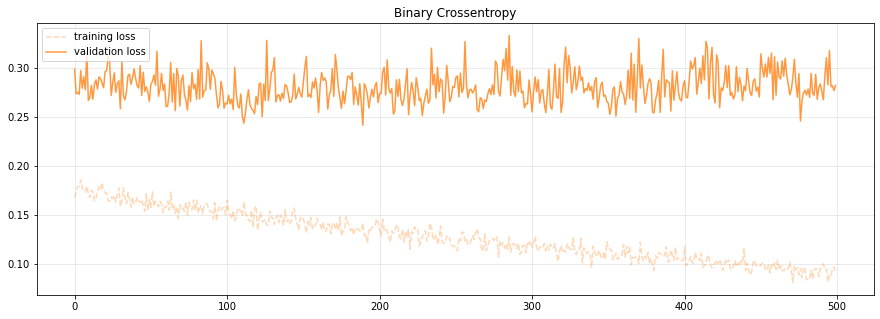

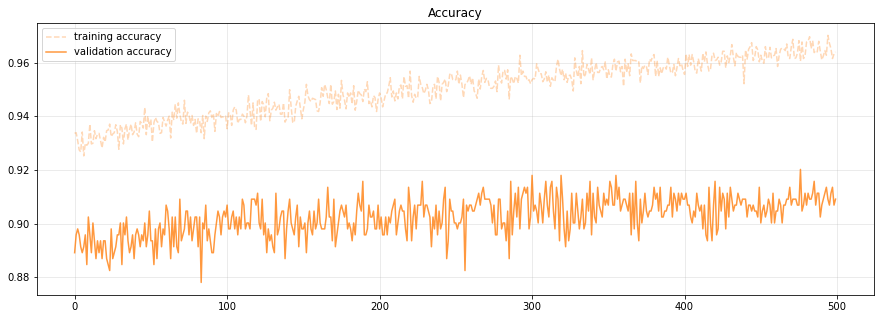

In [36]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)


plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Fine Tuning

In [ ]:
# Load the model for fine tuning and print the summary
ft_model = tfk.models.load_model('Model_trainaug')
ft_model.summary()

In [ ]:
# Set all layers of the pretrained model equal to true 
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers):
   layer.trainable=True 
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers
N = 176
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model with a lower learning rate
ft_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(5e-6),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_gen,
    validation_data = val_gen,
    batch_size = 32,
    epochs = 300,
    callbacks = callbacks
).history

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
#plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
#plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
#plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
#plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)


In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(X_test,y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

## Model Evaluation

### Testing

In [38]:
# Load the best model from directory
best_model = tfk.models.load_model('experiments/epoch477')

In [39]:
# Evaluate on the test set
test_acc = best_model.evaluate(X_test, y_test, verbose=0)[-1]
print("Test set accuracy is %.4f"% test_acc)

Test set accuracy is 0.9142


In [40]:
# Predict labels for the entire test set
predictions = best_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (501, 2)


Accuracy: 0.9142
Precision: 0.9152
Recall: 0.9002
F1: 0.9067


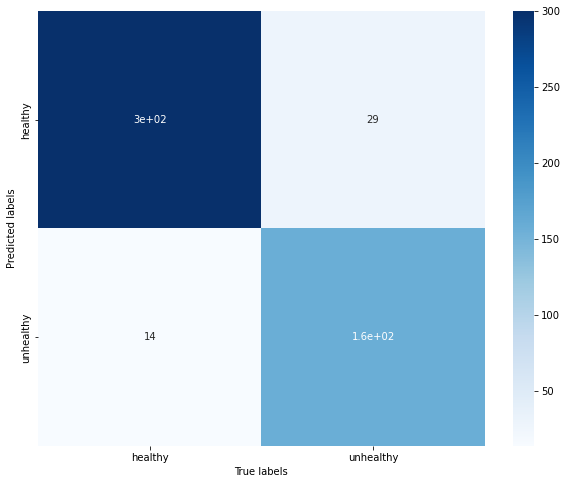

In [41]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Test Time Augmentation

#### Prediction1

Augment a wide range of images on test set

In [ ]:
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm


preprocessing = tfk.Sequential([
    tfkl.RandomFlip('horizontal',name='RandomFlip_horizontal'),
    tfkl.RandomFlip('vertical',name='RandomFlip_vertical'),
    #tfkl.RandomBrightness(0.1)
    #tfkl.RandomZoom(0.2),
    #tfkl.RandomTranslation(0.2,0.2),
], name = 'preprocessing')

def predict1(X,model):
    
    out = []
    
    for idx in tqdm_notebook(range(X.shape[0])):
        
        x = X[idx]
        
        images_to_predict = []
        images_to_predict.append(x)
    
        for i in range(25):
            augment_image = preprocessing(x)
            #augment_image = datagenerator.random_transform(x)
            images_to_predict.append(augment_image)
            
        images_to_predict = np.array(images_to_predict)
        predictions = model.predict(images_to_predict, verbose=0)
        mean_prediction = np.mean(predictions, axis=0)
        out.append(mean_prediction)
        
    return tf.stack(out)

In [ ]:
# Predict labels for the entire test set
predictions_ttda = predict_prob(X_test, model)

# Display the shape of the predictions
print("Predictions Shape:", predictions_ttda.shape)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('items','animals')), yticklabels=list(('items','animals')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### Prediction2

In [ ]:
def predict2(X,model):

        # Insert your preprocessing here

        assert X.ndim == 4

        # X = X/255.
        X = tf.keras.applications.efficientnet_v2.preprocess_input(X)

        predicts = []

        fs = [tf.image.flip_left_right, tf.image.flip_up_down, tf.image.transpose]
        for f in fs:
            data = f(X)
            pred = model.predict(data)
            predicts.append(pred)

        prediction = model.predict(X)

        for j in range(0, len(predicts)):
            prediction += predicts[j]
        prediction = prediction / (1 + len(predicts))

        #output = tf.argmax(prediction, axis=-1)

        return prediction

In [ ]:
# Predict labels for the entire test set
predictions_ttda = predict2(X_test, model)

# Display the shape of the predictions
print("Predictions Shape:", predictions_ttda.shape)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('items','animals')), yticklabels=list(('items','animals')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Data Visualization

We can visualize what are the images that our model mispredicted

In [ ]:
def visualize_data(images, categories=None, class_names=None):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(min(3 * 7, len(images))):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        if class_names and categories is not None:
            class_index = categories[i].argmax()
            plt.xlabel(class_names[class_index])
    plt.show()

In [ ]:
#true classes
t = np.argmax(y_test, axis=-1)

#predicted classes
p = np.argmax(predictions_ttda, axis=-1)

#mispredicted indices
miss_indices = np.where(t!=p)
print(miss_indices)

In [ ]:
# visualize mispredicted data
mispred = np.array([x for x in X[miss_indices]])
visualize_data(mispred[(21*1):]/255)
visualize_data(mispred[(21*2):]/255)
visualize_data(mispred[(21*3):]/255)